**Author :** Sathiyanarayanan Senthil Kumar\
**Date:** 11 September 2024

**Running Analysis**\
**Event Performance Predictor**\
**(A) Introduction**
* The Event Performance Predictor is a sophisticated tool designed to estimate an athlete’s potential finish time for an upcoming event (Example: Race Day). This prediction is based on a combination of historical performance data, current fitness metrics, and race-specific conditions. By providing an accurate estimate, this tool aids athletes in setting realistic goals and optimizing their race strategy.

**(B) Purpose and Focus**
* **Purpose:** To predict an athlete's overall performance, specifically focusing on the finish time for an upcoming event.
* **Primary Concern:** To understand how an athlete’s current fitness, race-specific details (such as course elevation, weather forecast, and race distance), and known variables (like VO2 Max) will influence their ability to complete a race.

**(C) Variables used**\
**(i) Necessary variables: (Available in the dataset)**

* Average Speed in km/h
* Average Heart Rate (bpm)
* Max. Heart Rate (bpm)
* Min. Heart Rate (bpm)
* Elevation Gain (Raw)
* Elevation Loss (Raw)
* Temperature (Raw) (C)
* Wind Speed (Raw) (m/s)
* Humidity (Raw) (%)
* Distance (Raw) (km)

**(ii) The following metrics can be calculated from the above:**
* Heart Rate Reserve (HRR)
* VO2_Max_in_mL/kg/min
* Running_Efficiency
* Pace_in_min/km
* Running Duration **(Target variable)**


**Assumption:**

As the data in 'Fixed_cleaned_activities.csv' is sourced from the internet, I am making the following assumptions:

* All rows in the dataset represent records for the same individual, taken on different training dates. For future applications involving actual datasets, a User_ID or a unique identifier could be used to filter data specific to each user.

**Limitation:**

* This model is not limited to predicting race outcomes. If a device can continuously capture the necessary physiological and performance variables listed above, along with a few environmental variables and race distance, it can predict the finishing time before the user even begins to run. The prediction accuracy would improve as more high-quality historical data is recorded.

**1. Loading the Dataset**

In this step the code mounts Google Drive to access the dataset and loads it using Pandas. The dataset Fixed_cleaned_activities.csv is read into a DataFrame (df), which will be used for the analysis.

In [22]:
import pandas as pd
from google.colab import drive

# Mounting googlr drive for accessing the df
drive.mount('/content/drive')

# Loading the dataset
file_path = '/content/drive/My Drive/Colab Notebooks/Fixed_cleaned_activities.csv'
df = pd.read_csv(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**2. Calculating Performance Metrics**\
This section calculates key performance metrics for the dataset.
* **Pace (min/km):** Calculated as 60 divided by average speed.
* **VO2 Max:** Estimated using Cooper’s formula based on speed.
* **Running Efficiency:** Ratio of average speed to average heart rate.
* **Heart Rate Reserve (HRR):** Difference between max and min heart rate.
* **Running Duration:** Calculated as distance divided by average speed.

These metrics are then added as new columns to the DataFrame for further analysis.

In [23]:
# Functions for calculating necessary variables

# 1. Pace in min/km
def calculate_pace(avg_speed):
  avg_pace = 60 / avg_speed
  return avg_pace

# 2. VO2 Max in mL/kg/min using Cooper's formula
def calculate_vo2_max(speed_kmh):
  distance_km = speed_kmh * (12 / 60)
  vo2_max = (22.351 * distance_km) - 11.288
  return vo2_max

# 3. Running Efficiency
def calculate_running_efficiency(avg_speed, avg_heart_rate):
    if avg_heart_rate > 0:
        return avg_speed / avg_heart_rate
    return 0  # To handle division by zero if heart rate is missing

# 4. Heart Rate Reserve (HRR)
def calculate_hrr(max_heart_rate, min_heart_rate):
    return max_heart_rate - min_heart_rate

# 5. Running Duraion
def calculate_running_duration(distance, avg_speed):
    if avg_speed > 0:
        time = distance / avg_speed
        return time
    return 0  # To handle division by zero if speed is missing


# Applying the above functions to the df
df['Pace_in_min/km'] = df['Average Speed'].apply(calculate_pace)
df['VO2_Max_in_mL/kg/min'] = df['Average Speed'].apply(calculate_vo2_max)
df['Running_Efficiency'] = df.apply(lambda row: calculate_running_efficiency(row['Average Speed'], row['Average Heart Rate (bpm)']), axis=1)
df['HRR'] = df.apply(lambda row: calculate_hrr(row['Max. Heart Rate (bpm)'], row['Min. Heart Rate (bpm)']), axis=1)
df['Running_Duration_hours'] = df.apply(lambda row: calculate_running_duration(row['Distance (Raw)'], row['Average Speed']), axis=1)

**3. Visualizing Performance Metrics Over Time**

* **Date Format Correction:** The 'Begin Timestamp' column is converted to a datetime format for proper time-based plotting.
* **Key Metrics:** Selected metrics (Pace, VO2 Max, Running Efficiency, HRR, and Average Speed) are visualized.
* **Plotting:** For each metric, a line plot is generated showing its trend over time, using the corrected 'Begin Timestamp' as the x-axis.
These visualizations provide insights into how the individual's performance metrics have evolved over time.

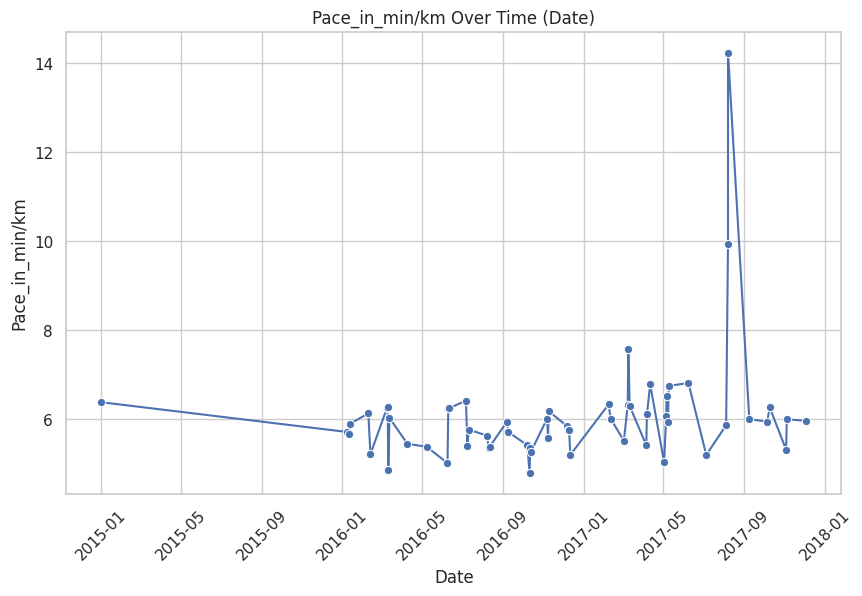

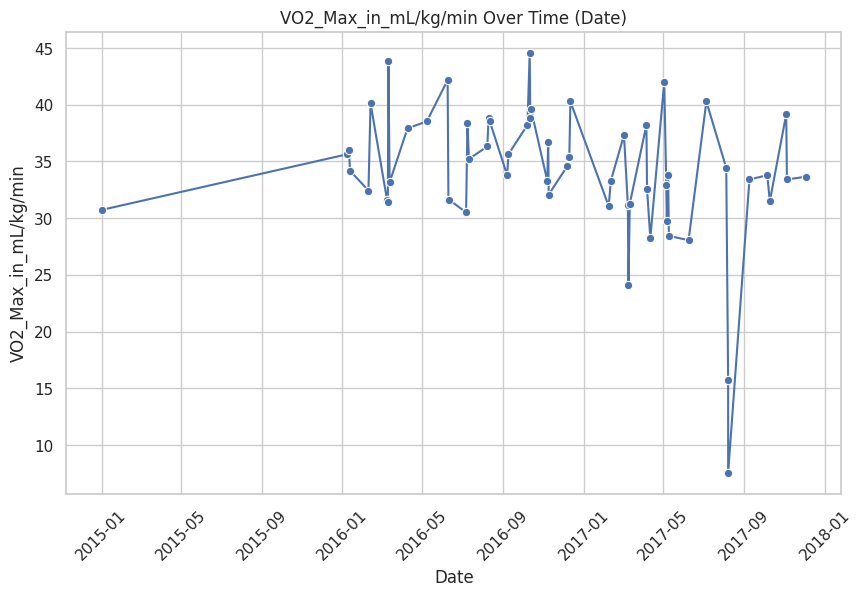

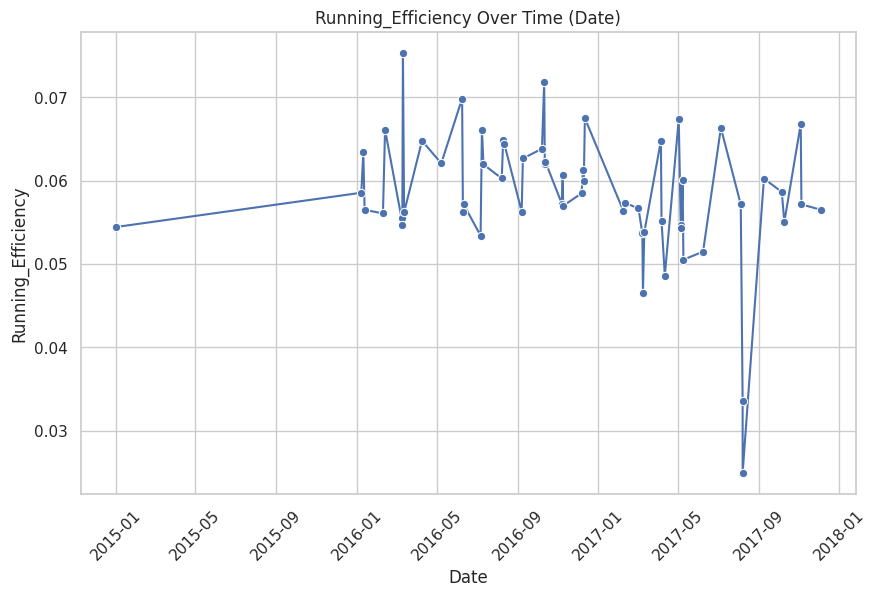

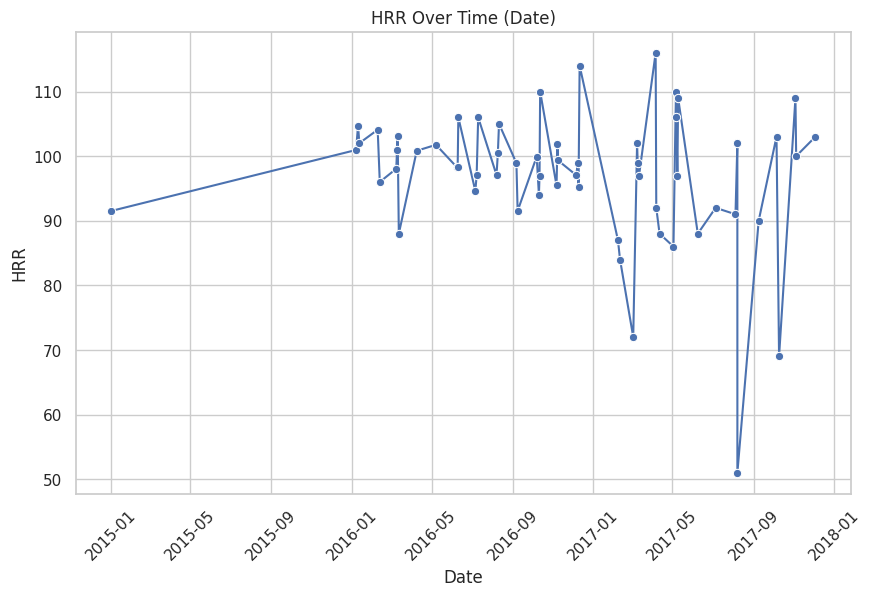

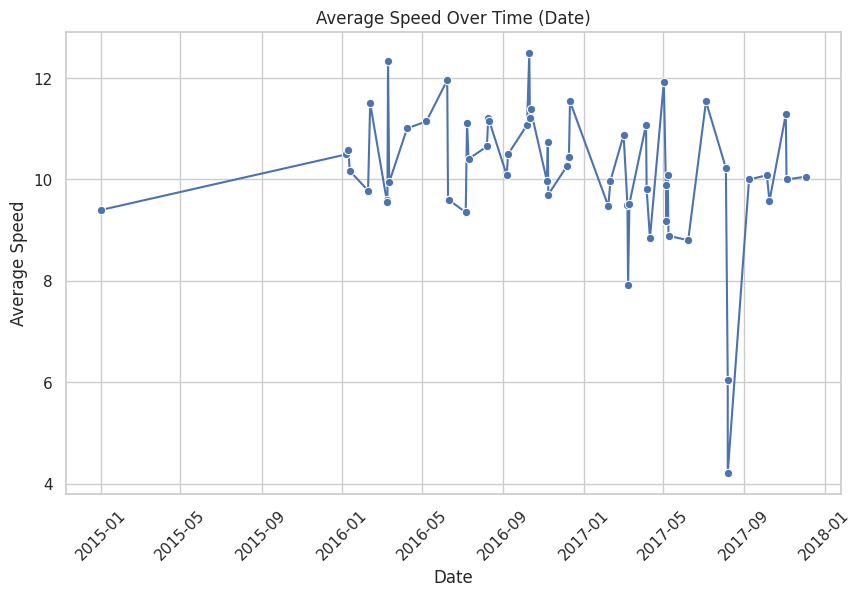

In [24]:
# Visualizations
# Correcting the date format
df['Begin Timestamp'] = pd.to_datetime(df['Begin Timestamp'], errors='coerce')

# Plotting the performance metrics over time using the 'Begin Timestamp' for the x-axis
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the plotting style
sns.set(style="whitegrid")

# Defining the key metrics to plot over time
key_metrics = ['Pace_in_min/km', 'VO2_Max_in_mL/kg/min', 'Running_Efficiency', 'HRR', 'Average Speed']

# Now plotting the metrics over time
for metric in key_metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=df['Begin Timestamp'], y=df[metric], marker='o')
    plt.title(f'{metric} Over Time (Date)')
    plt.xlabel('Date')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()





**4. Selecting Variables for Modeling**

* **Physiological Variables:** Includes heart rate, HRR, VO2 Max, and running efficiency.
* **Performance Metrics:** Focuses on pace and average speed.
* **Environmental Variables:** Captures elevation gain/loss, temperature, wind speed, and humidity.
* **Performance-Related Variables:** Includes distance.

These variables are combined into a feature set for use in the machine learning model.

In [25]:
# Selecting required variables and metrics for modelling
# Physiological Variables
physiological_vars = ['Average Heart Rate (bpm)', 'Max. Heart Rate (bpm)', 'Min. Heart Rate (bpm)',
                      'HRR', 'VO2_Max_in_mL/kg/min', 'Running_Efficiency']

# Performance Metrics
performance_metrics = ['Pace_in_min/km', 'Average Speed']

# Environmental Variables
environmental_vars = ['Elevation Gain (Raw)', 'Elevation Loss (Raw)', 'Temperature (Raw)',
                      'Wind Speed (Raw)', 'Humidity (Raw)']

# Performance-Related Variables
performance_related_vars = ['Distance (Raw)']

# Combining all into the features set
features_columns = physiological_vars + performance_metrics + environmental_vars + performance_related_vars

**5. Comparing Machine Learning Models**\
In this section, different machine learning models are trained and evaluated to predict the athlete's race finish time.

**(i) Libraries**\
Necessary libraries for data splitting, model building, and performance evaluation are imported.

**(ii) Model Selection**\
Six regression models are chosen:

* Linear Regression
* Random Forest
* Gradient Boosting
* Support Vector Regressor
* K-Nearest Neighbors
* Decision Tree Regressor

These models are stored in a dictionary for easy comparison.

**(iii) Data Preparation**
* **Features:** Selected from the dataset, including physiological, performance, and environmental variables.
* **Target:** The finish time (Running_Duration_hours) is set as the prediction target.

**(iv) Data Split**\
The data is split into 80% training and 20% test sets using train_test_split for model training and evaluation.

**(v) Model Training and Evaluation**\
Each model is trained on the training data, and predictions are made on the test set. The models are evaluated using:

* MAE (Mean Absolute Error)
* MSE (Mean Squared Error)
* RMSE (Root Mean Squared Error)
* R² Score
* Explained Variance

**(vi) Results**\
The evaluation metrics for each model are printed, allowing easy comparison to determine which model predicts the finish time most accurately.

In [26]:
# Importing necessary libraries for model comparison
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score

# List of models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

# Preparing features and target variable
features = df[features_columns]
target = df['Running_Duration_hours']  # Target variable

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Comparing the models
results = {}

for name, model in models.items():
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluating the model using multiple metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    evs = explained_variance_score(y_test, y_pred)

    # Storing results
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2,
        'Explained Variance': evs
    }

# Displaying the results
for model_name, metrics in results.items():
    print(f"{model_name} - MAE: {metrics['MAE']}, MSE: {metrics['MSE']}, RMSE: {metrics['RMSE']}, "
          f"R² Score: {metrics['R² Score']}, Explained Variance: {metrics['Explained Variance']}")


Linear Regression - MAE: 0.02392411101315797, MSE: 0.002089129165899437, RMSE: 0.04570699252739603, R² Score: 0.9836250701473463, Explained Variance: 0.9847349562415492
Random Forest - MAE: 1.4973112805725826, MSE: 65.51041470767782, RMSE: 8.093850425333905, R² Score: -512.4811494504354, Explained Variance: -496.3158004197758
Gradient Boosting - MAE: 0.03664270875105197, MSE: 0.005719576054674793, RMSE: 0.07562787881908889, R² Score: 0.9551690444942429, Explained Variance: 0.9572136307361989
Support Vector Regressor - MAE: 0.08806324738389586, MSE: 0.01886217791793718, RMSE: 0.13733964437822452, R² Score: 0.8521552207895597, Explained Variance: 0.8532332553401856
K-Nearest Neighbors - MAE: 0.11681595102150537, MSE: 0.0274475611012317, RMSE: 0.16567305484366399, R² Score: 0.7848616088485894, Explained Variance: 0.7878268328321264
Decision Tree - MAE: 0.03772103709677419, MSE: 0.005786867727652739, RMSE: 0.07607146460830591, R² Score: 0.9546416015564545, Explained Variance: 0.95641811268

**Understanding the Results**\
By comparing multiple models using key metrics such as MAE, MSE, RMSE, R², and Explained Variance, the following conclutions can be made:  

* **Linear Regression:** Linear Regression performs exceptionally well. Its low error metrics and high R² show that it fits the data almost perfectly.
* **Random Forest:** Random Forest is the worst performer with extremely high errors and a negative R², indicating it doesn't fit the data at all.
* **Gradient Boosting:** Gradient Boosting shows strong performance, second only to Linear Regression, with slightly higher errors but still a good fit.
* **Support Vector Regressor (SVR):** SVR is a decent performer, though it has higher errors and explains less variance than Gradient Boosting and Linear Regression.
* **K-Nearest Neighbors (KNN):** KNN has the highest errors after Random Forest, showing weaker performance and less ability to explain the variance.
* **Decision Tree:** Decision Tree performs similarly to Gradient Boosting, with low errors and good model fit, making it a strong contender.

**Summary:**
* **Best Model:** Linear Regression is the top performer with the lowest errors and the best fit.
* **Strong Contenders:** Gradient Boosting and Decision Tree also perform well.
* **Worst Performer:** Random Forest shows the highest errors and an extremely poor fit, making it unsuitable for this dataset.

**Note:** For the "*Fixed_cleaned_activities.csv*" dataset, **"Linear Regression"** is the most suitable model. So, I am going to predict the result using it.


**6. Predicting Finish Time for a new Event**

**(i) Model Fitting (Linear Regression):**\
A Linear Regression model is trained using the dataset to predict race finish times. The features include various physiological, performance, and environmental metrics, and the target variable is the **Running_Duration_hours** (finish time). After training, the model is ready to make predictions.

**(ii) Calculating Historical Averages:**\
To account for the runner’s current form, data from the most recent 6 months is selected, and the averages of key physiological and performance metrics (e.g., heart rate, VO2 Max, running efficiency) are calculated. These historical averages provide the baseline for understanding the runner's performance trends.

**(iii) Function Definitions:**
* **predict_finish_time:** Combines historical averages with race-specific details to predict the finish time. The input is converted into the correct format and used by the model to make predictions.
* **print_race_details:** Displays the race-specific details such as elevation, temperature, wind speed, and distance.
* **format_time:** Converts the predicted finish time from hours into a more readable "hh:mm:ss" format.

**(iv) Race Example Predictions:**\
Two race examples are provided to demonstrate how the model works. The race-specific details for each example are printed, followed by the predicted finish time in hours, minutes, and seconds.

**(v) User Input for Prediction:**\
The user is prompted to enter race-specific details, such as elevation gain, temperature, and distance. The predict_finish_time function combines these inputs with the runner’s historical averages and predicts the finish time for the upcoming race, displaying it in a readable format.

In [27]:
import pandas as pd
from datetime import timedelta
from sklearn.linear_model import LinearRegression

# Section 1: Model Fitting (Linear Regression)
# Defining the Linear Regression model
model = LinearRegression()

# Preparing features and target variable
features = df[features_columns]
target = df['Running_Duration_hours']  # Target variable: finish time

# Training the Linear Regression model
model.fit(features, target)
print("Linear Regression model has been trained on the data.\n")

# Section 2: Historical averages  for physiological and performance metrics
# Selecting data from the most recent 6 months for knowing the runner's latest form
df['Begin Timestamp'] = pd.to_datetime(df['Begin Timestamp'])
last_date = df['Begin Timestamp'].max()
start_date = last_date - timedelta(days=180)  # Approx. 6 months (180 days)
recent_data = df[df['Begin Timestamp'] >= start_date]
print(f"To take the runner's current form into consideration, the runner's most recent ' historical data average (mean) from {start_date} to {last_date} (6 months) is calculated.")

# Calculating historical averages for physiological and performance metrics using recent 6 months data
historical_averages = {
    'Average Heart Rate (bpm)': recent_data['Average Heart Rate (bpm)'].mean(),
    'Max. Heart Rate (bpm)': recent_data['Max. Heart Rate (bpm)'].mean(),
    'Min. Heart Rate (bpm)': recent_data['Min. Heart Rate (bpm)'].mean(),
    'HRR': recent_data['HRR'].mean(),
    'VO2_Max_in_mL/kg/min': recent_data['VO2_Max_in_mL/kg/min'].mean(),
    'Running_Efficiency': recent_data['Running_Efficiency'].mean(),
    'Pace_in_min/km': recent_data['Pace_in_min/km'].mean(),
    'Average Speed': recent_data['Average Speed'].mean()
}

# Section 3: Function definitions
# Function to predict finish time
def predict_finish_time(race_details, model, features_columns, historical_averages):
    # Combining historical averages with race-specific details
    combined_data = {**historical_averages, **race_details}

    # Converting the combined data into the correct order based on features_columns
    new_event = [combined_data[feature] for feature in features_columns]

    # Creating a DataFrame for the new event
    new_event_df = pd.DataFrame([new_event], columns=features_columns)

    # Making a prediction
    predicted_time = model.predict(new_event_df)
    return predicted_time[0]

# Function to print race-specific details
def print_race_details(race_details):
    print(f"Elevation Gain: {race_details['Elevation Gain (Raw)']} m")
    print(f"Elevation Loss: {race_details['Elevation Loss (Raw)']} m")
    print(f"Temperature: {race_details['Temperature (Raw)']} °C")
    print(f"Wind Speed: {race_details['Wind Speed (Raw)']} km/h")
    print(f"Humidity: {race_details['Humidity (Raw)']} %")
    print(f"Distance: {race_details['Distance (Raw)']} km")

# Helper function to convert float hours into hh:mm:ss format
def format_time(hours):
    h = int(hours)
    m = int((hours - h) * 60)
    s = int(((hours - h) * 60 - m) * 60)
    return f"{h}:{m}:{s} (hh:mm:ss)"


# Section 4: Examples
# Race-specific details for examples
# Example Race 1
race_example_1 = {
    'Elevation Gain (Raw)': 250,
    'Elevation Loss (Raw)': 200,
    'Temperature (Raw)': 12,
    'Wind Speed (Raw)': 8,
    'Humidity (Raw)': 65,
    'Distance (Raw)': 15
}

# Prediction for race example 1
print("\nRace Example 1 Details:")
print_race_details(race_example_1)
predicted_time_example_1 = predict_finish_time(race_example_1, model, features_columns, historical_averages)
print(f'Predicted Finish Time for race example 1: {format_time(predicted_time_example_1)}')

# Example Race 2
race_example_2 = {
    'Elevation Gain (Raw)': 100,
    'Elevation Loss (Raw)': 120,
    'Temperature (Raw)': 18,
    'Wind Speed (Raw)': 3,
    'Humidity (Raw)': 55,
    'Distance (Raw)': 5
}

# Prediction for race example 2
print("\nRace Example 2 Details:")
print_race_details(race_example_2)
predicted_time_example_2 = predict_finish_time(race_example_2, model, features_columns, historical_averages)
print(f'Predicted Finish Time for race example 2: {format_time(predicted_time_example_2)}')

print("\nThe above example shows how the model works. Please enter the race specific details in the requested format to predict your race outcome!\n")

# Section 5: User Input
user_input = {
    'Elevation Gain (Raw)': float(input("Enter the elevation gain (in meters): ")),
    'Elevation Loss (Raw)': float(input("Enter the elevation loss (in meters): ")),
    'Temperature (Raw)': float(input("Enter the temperature (in °C): ")),
    'Wind Speed (Raw)': float(input("Enter the wind speed (in km/h): ")),
    'Humidity (Raw)': float(input("Enter the humidity (in %): ")),
    'Distance (Raw)': float(input("Enter the distance (in km): "))
}

# Prediction for user input
print("\nUser Input Race Details:")
print_race_details(user_input)
predicted_time_user_input = predict_finish_time(user_input, model, features_columns, historical_averages)
print(f'Predicted Finish Time for user input: {format_time(predicted_time_user_input)}')


Linear Regression model has been trained on the data.

To take the runner's current form into consideration, the runner's most recent ' historical data average (mean) from 2017-06-06 14:49:00 to 2017-12-03 14:49:00 (6 months) is calculated.

Race Example 1 Details:
Elevation Gain: 250 m
Elevation Loss: 200 m
Temperature: 12 °C
Wind Speed: 8 km/h
Humidity: 65 %
Distance: 15 km
Predicted Finish Time for race example 1: 1:30:42 (hh:mm:ss)

Race Example 2 Details:
Elevation Gain: 100 m
Elevation Loss: 120 m
Temperature: 18 °C
Wind Speed: 3 km/h
Humidity: 55 %
Distance: 5 km
Predicted Finish Time for race example 2: 0:33:30 (hh:mm:ss)

The above example shows how the model works. Please enter the race specific details in the requested format to predict your race outcome!

Enter the elevation gain (in meters): 245
Enter the elevation loss (in meters): 240
Enter the temperature (in °C): 22.8
Enter the wind speed (in km/h): 14
Enter the humidity (in %): 65
Enter the distance (in km): 7.34

Use